In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import seaborn as sns
import numpy as np
import math
from pingouin import multivariate_normality
from scipy.stats import chi2
from matplotlib import patches

In [148]:
kcl_Directory = "/Users/noahlippman/Documents/kclData"
kcl_files = glob.glob(os.path.join(kcl_Directory, "*.csv"))
data = pd.read_csv(kcl_files[0])

for f in kcl_files[1:]:
    newGame = pd.read_csv(f)
    data = pd.concat([data,newGame], axis = 0)

air_data = data[(data['HitType'] != "GroundBall") & 
                (data['HitType'] != "Throwdown") &
                (data['ExitSpeed'].notna()) & 
                (data['Angle'].notna()) & 
                (data['Bearing'].notna()) &
                (data['HangTime'].notna()) &
                (data['PitchCall'] == "InPlay") &
                (data['PlayResult'].notna()) &
                (~data['Position'].isin([1,2]))]

len(air_data)

686

In [149]:
color_dict = {0: '#ff1100', 1: "#2721c4",2:"#7d107aed",3:"#a29006ec",4:"#c54306ec",
              5:"#066967ec", 6: "#7a06ffeb", 7: "#ff0000", 8: "#00ff73ec", 9: "#080708ec"}

air_data['Bearing'] = air_data['Bearing'] * math.pi / 180
air_data['X_Cord'] = np.sin(air_data['Bearing']) * air_data['Distance']
air_data['Y_Cord'] = np.cos(air_data['Bearing']) * air_data['Distance']
air_data['Position'] = air_data['Position'].fillna(0)
air_data['Color'] = air_data['Position'].map(color_dict)
pd.unique(air_data['Position'])

/var/folders/vd/06ct10nj485cm3hk0nq7zy8h0000gn/T/ipykernel_37194/3981163140.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_data['Bearing'] = air_data['Bearing'] * math.pi / 180
/var/folders/vd/06ct10nj485cm3hk0nq7zy8h0000gn/T/ipykernel_37194/3981163140.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_data['X_Cord'] = np.sin(air_data['Bearing']) * air_data['Distance']
/var/folders/vd/06ct10nj485cm3hk0nq7zy8h0000gn/T/ipykernel_37194/3981163140.py:6: SettingWithCopyWarning: 
A value is trying t

array([0., 9., 4., 6., 7., 8., 3., 5.])

In [150]:
pd.unique(air_data['PlayResult'])

array(['HomeRun', 'Out', 'Single', 'Double', 'Error', 'Triple',
       'Sacrifice'], dtype=object)

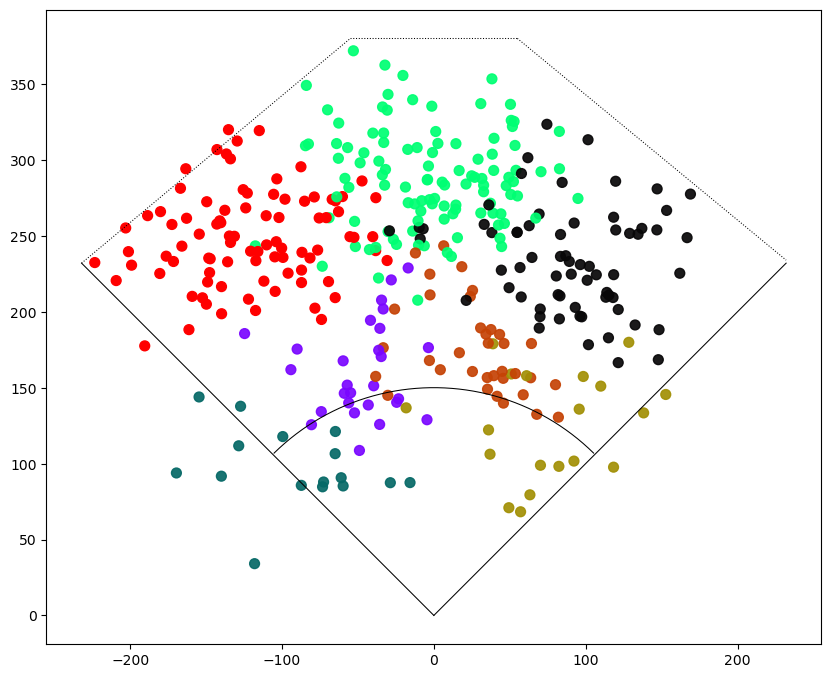

In [151]:
y_max = np.max(air_data['Y_Cord'])
outs = air_data[air_data['Position'] != 0]

theta = np.linspace(0, np.pi, 100)
radius = 150
x = radius * np.cos(theta)
y = radius * np.sin(theta)
semicircle = pd.DataFrame({'X':x,'Y':y})
semicircle = semicircle[(semicircle['X'] > -106) & (semicircle['X'] < 106)]

plt.figure(figsize=(10,10))
plt.scatter(outs['X_Cord'], outs['Y_Cord'], c = outs['Color'], s = 50)
plt.plot([0, 232], [0, 232], color='black', linewidth=0.75)
plt.plot([0, -232], [0, 232], color='black', linewidth=0.75)
plt.plot([-232, -55], [232, 380], color='black', linestyle='dotted', linewidth=0.75)
plt.plot([-55, 55], [380, 380], color='black', linestyle='dotted', linewidth=0.75)
plt.plot([55, 232], [380, 234], color='black', linestyle='dotted', linewidth=0.75)
plt.plot(semicircle['X'], semicircle['Y'], color='black', linewidth=0.75)
plt.gca().set_aspect('equal')
plt.show()

xgboost model using coordinates and hang time as features

In [152]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

X = air_data[['X_Cord', 'Y_Cord', 'HangTime']]
Y = [i - 2 if i != 0 else i for i in air_data['Position']]

model = xgb.XGBClassifier(objective = "multi:softprob", num_class = 8)

param_grid = {
    'max_depth': [2,3,4,5],
    'learning_rate': [.01,.1,.2,.3],
    'n_estimators': [50,100,200]
}
grid = GridSearchCV(model, param_grid, scoring= "neg_log_loss", cv=5)
grid.fit(X,Y)
print("Best Paramaters:", grid.best_params_)
print("Best log loss:", -grid.best_score_)

Best Paramaters: {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 50}
Best log loss: 0.770386869805417


xgboost model using exit velo, angle, bearing and hang time as features

In [153]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

X = air_data[['ExitSpeed', 'Angle', 'Bearing', 'HangTime']]
Y = [i - 2 if i != 0 else i for i in air_data['Position']]

model = xgb.XGBClassifier(objective = "multi:softprob", num_class = 8)

param_grid = {
    'max_depth': [2,3,4,5],
    'learning_rate': [.01,.1,.2,.3],
    'n_estimators': [50,100,200]
}
grid = GridSearchCV(model, param_grid, scoring= "neg_log_loss", cv=5)
grid.fit(X,Y)
print("Best Paramaters:", grid.best_params_)
print("Best log loss:", -grid.best_score_)

Best Paramaters: {'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 50}
Best log loss: 0.7742781707842489


KNN Model using coordinates and hangtime as features

Text(55.847222222222214, 0.5, 'log loss')

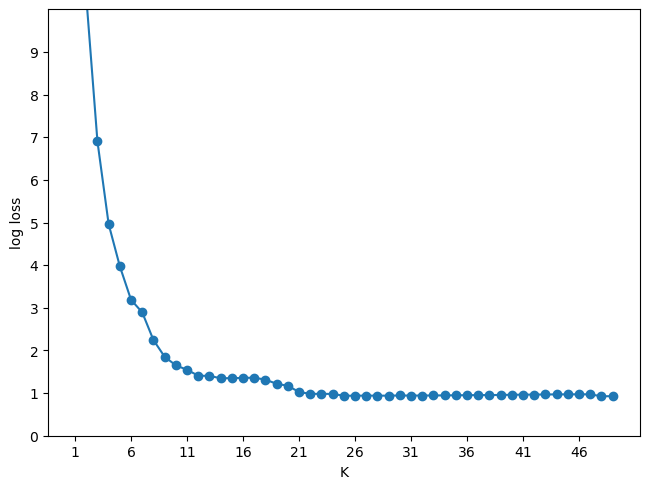

In [154]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

X = air_data[['X_Cord', 'Y_Cord', 'HangTime']]
Y = [i - 2 if i != 0 else i for i in air_data['Position']]


def CV():
    k_scores = {}
    for i in range(1,50):
        model = KNeighborsClassifier(n_neighbors = i)
        k_folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state=8)
        scores = cross_val_score(model, X, Y, cv = k_folds, scoring = 'neg_log_loss') * -1
        k_scores[i] = scores.mean()
    return k_scores

scores = CV()


K_vals = scores.keys()
log_loss_vals = scores.values()
plt.scatter(K_vals,log_loss_vals)
plt.plot(K_vals,log_loss_vals)
plt.xticks([i for i in range(1,50, 5)])
plt.ylim(0,10)
plt.yticks([i for i in range(0,10,1)])
plt.tight_layout()
plt.xlabel("K")
plt.ylabel("log loss")


In [160]:
X = air_data[['X_Cord', 'Y_Cord', 'HangTime']]
Y = [i - 2 if i != 0 else i for i in air_data['Position']]
model = xgb.XGBClassifier(learning_rate = .3, max_depth = 2, n_estimators = 50)
model.fit(X,Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)

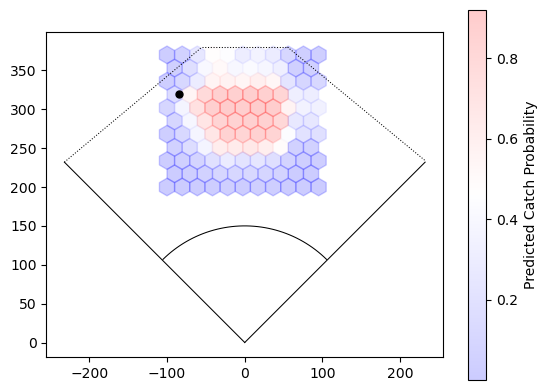

In [257]:
from itertools import product

x_cords = [i for i in range(-100, 100, 5)]
y_cords = [i for i in range(200,375,5)]
hangTime = [4.6]

cords = pd.DataFrame(list(product(x_cords, y_cords, hangTime)), columns = ['X_Cord', 'Y_Cord', 'HangTime'])

CF_Probs = [i[6] for i in model.predict_proba(cords)]

plt.hexbin(cords['X_Cord'],cords['Y_Cord'],C = CF_Probs, gridsize=10, cmap = 'bwr', alpha=.2)
plt.colorbar(label = "Predicted Catch Probability")
plt.scatter([-85],[320], c="black", alpha = 1, s = 25)
plt.plot([0, 232], [0, 232], color='black', linewidth=0.75)
plt.plot([0, -232], [0, 232], color='black', linewidth=0.75)
plt.plot([-232, -55], [232, 380], color='black', linestyle='dotted', linewidth=0.75)
plt.plot([-55, 55], [380, 380], color='black', linestyle='dotted', linewidth=0.75)
plt.plot([55, 232], [380, 234], color='black', linestyle='dotted', linewidth=0.75)
plt.plot(semicircle['X'], semicircle['Y'], color='black', linewidth=0.75)
plt.gca().set_aspect('equal')
plt.show()

In [ ]:
def playUZR(dataFrame):
    probDict = {3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
    position = dataFrame['Position']
    probs = model.predict_proba(np.array([[dataFrame['X_Cord'], dataFrame['Y_Cord'], dataFrame['HangTime']]]))
    outProb = 1 - probs[0][0]
    probsList = dict(zip(range(3,10), probs[0][1:]))
    if(dataFrame['PlayResult'] == "HomeRun"):
        probDict['PitchUUID'] = dataFrame['PitchUUID']
        return probDict
    elif (position == 0):
        probDict = dict(zip([i for i in probsList.keys()],[-i if i > .01 else 0 for i in list(probsList.values())]))
        probDict['PitchUUID'] = dataFrame['PitchUUID']
        return(probDict)
    else:
        probDict[position] = 1 - (outProb)
        probDict['PitchUUID'] = dataFrame['PitchUUID']
        return probDict

In [239]:
scores = air_data[['PitchUUID','PlayResult','Position', 'X_Cord', 'Y_Cord', 'HangTime']].apply(playUZR, axis = 1)
row = [i for i in scores]
scoresData = pd.DataFrame.from_dict(row)

In [ ]:
dataWithScores = pd.merge(air_data, scoresData, on = 'PitchUUID', how = 'inner')
dataWithScores.to_csv('/Users/noahlippman/Documents/KCL_Defense/DefenseData')
positionalCols = ['Home2', 'Home3', 'Home4', 'Home5', 'Home6', 'Home7', 'Home8', 'Home9',
                       'Away2', 'Away3', 'Away4', 'Away5', 'Away6', 'Away7', 'Away8', 'Away9']
def playerData(player):
    individualData = dataWithScores[
                        ((dataWithScores['Top/Bottom'] == 'Bottom') &
                        (dataWithScores[['Away2', 'Away3', 'Away4', 'Away5', 'Away6', 'Away7', 'Away8', 'Away9']]
                        .isin([player]).any(axis=1))) |
                        ((dataWithScores['Top/Bottom'] == 'Top') &
                        (dataWithScores[['Home2', 'Home3', 'Home4', 'Home5', 'Home6', 'Home7', 'Home8', 'Home9']]
                        .isin([player]).any(axis=1)))
                    ]
    mask = dataWithScores[positionalCols] == player

    player_position = mask.apply(lambda row: int(row[::-1].idxmax()[-1]) if row.any() else None, axis=1)
    individualData['playerPosition'] = player_position
    individualData['playScore'] = individualData.apply(
        lambda row: row[row['playerPosition']] if pd.notnull(row['playerPosition']) else None,
        axis=1
    )
    return individualData[['PlayResult','X_Cord', 'Y_Cord', 'HangTime', 3,4,5,6,7,8,9,'playerPosition', 'playScore']]

In [ ]:
playerData("Will Strehl").sort_values(by = "playScore", ascending = False)

/var/folders/vd/06ct10nj485cm3hk0nq7zy8h0000gn/T/ipykernel_37194/1869465197.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  individualData['playerPosition'] = player_position


KeyError: 2.0